<a href="https://colab.research.google.com/github/Jbarrera2000/Sales_Prediction_XGBoost/blob/main/Predicting_sales_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# get heper functions

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-11-04 04:16:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-04 04:16:59 (90.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb
from helper_functions import unzip_data

In [ ]:
unzip_data("/content/competitive-data-science-predict-future-sales.zip")

In [ ]:
df_sales_train=pd.read_csv("/content/sales_train.csv")
df_sales_test=pd.read_csv("/content/test.csv")
shops=pd.read_csv("/content/shops.csv")
items=pd.read_csv("/content/items.csv")
categories=pd.read_csv("/content/item_categories.csv")

In [ ]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
df_sales_train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [ ]:
# Group data by item_id and date_block_num (how many items per item_id were selled each month)
sales_by_item_id = df_sales_train.pivot_table(index=["item_id"], values=["item_cnt_day"],
                                              columns="date_block_num",
                                              aggfunc= np.sum,
                                              fill_value=0).reset_index()

sales_by_item_id.columns=sales_by_item_id.columns.droplevel().map(str) 
sales_by_item_id=sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0]="item_id"                                           
sales_by_item_id.head()

,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sales_by_item_id.sum()[1:]

0     131479
1     128090
2     147142
3     107190
4     106970
5     125381
6     116966
7     125291
8     133332
9     127541
10    130009
11    183342
12    116899
13    109687
14    115297
15     96556
16     97790
17     97429
18     91280
19    102721
20     99208
21    107422
22    117845
23    168755
24    110971
25     84198
26     82014
27     77827
28     72295
29     64114
30     63187
31     66079
32     72843
33     71056
dtype: int64

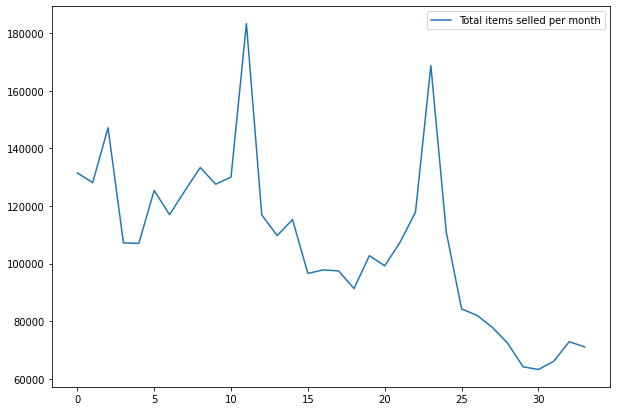

In [ ]:
sales_by_item_id.sum()[1:].plot(figsize=(10,7), legend=True, label="Total items selled per month")

In [ ]:
# Group train data by shop_id
sales_by_shop_id=df_sales_train.pivot_table(index=["shop_id"], values=["item_cnt_day"],
                                            columns="date_block_num",
                                            aggfunc=np.sum,
                                            fill_value=0).reset_index()

sales_by_shop_id.columns=sales_by_shop_id.columns.droplevel(0).map(str)      
sales_by_shop_id=sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0]="shop_id"                                      

sales_by_shop_id.head()                                            

,shop_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,5578,6127,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2947,3364,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1146,488,753,583,553,832,807,875,945,...,987,907,762,859,843,804,785,942,822,727
3,3,767,798,959,647,710,784,721,890,1026,...,977,738,741,740,731,672,535,666,745,613
4,4,2114,2025,2060,285,1211,1464,1378,1713,1536,...,1188,980,978,899,893,793,842,947,732,831


In [ ]:
sales_by_shop=sales_by_shop_id.sum(axis=1)[1:]
sales_by_shop

1       6312
2      30622
3      28358
4      43946
5      42767
6     100495
7      67065
8       3603
9      15875
10     24533
11       583
12     73490
13     19776
14     46389
15     71216
16     61649
17     25855
18     65504
19     73474
20      5892
21     68581
22     60252
23      7728
24     63910
25    241945
26     67916
27    136684
28    184585
29     58742
30     60858
31    310808
32      8813
33      5515
34      6485
35     69051
36       366
37     46293
38     53924
39     16656
40      4983
41     49365
42    144976
43     50651
44     44982
45     41940
46     79036
47     67684
48     24957
49     17139
50     76288
51     48818
52     49796
53     61710
54    185844
55     63443
56     78135
57    141164
58     81792
59     49052
dtype: int64

In [ ]:
len(sales_by_shop_id.index[1:])

59

In [ ]:
len(sales_by_shop)

59

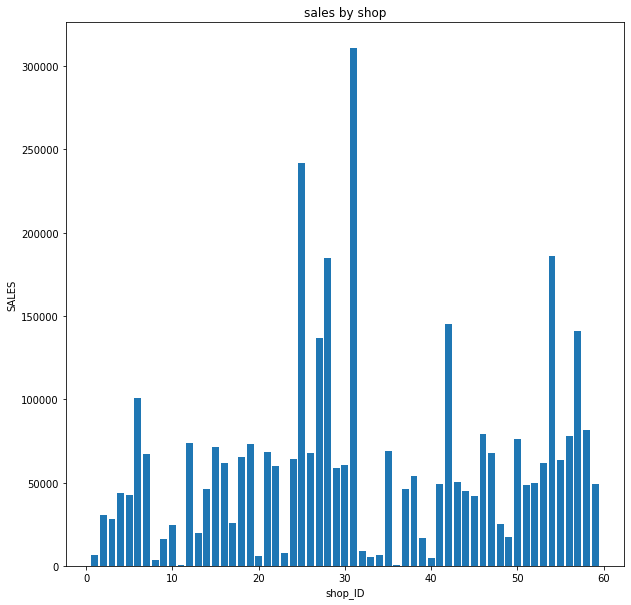

In [ ]:
plt.figure(figsize=(10, 10))
plt.bar(sales_by_shop_id.index[1:], sales_by_shop)
plt.title("sales by shop")
plt.xlabel("shop_ID")
plt.ylabel("SALES")
plt.show()

In [ ]:
# Converted train shop_id to shop_id that is in the test set
shops["shop_name"]= shops["shop_name"].apply(lambda x: x.lower()).str.replace("[^\w\s]","").str.replace("\d+","").str.strip()
shops["shop_city"]=shops["shop_name"].str.partition(" ")[0]
shops["shop_type"]=shops["shop_name"].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
shops.head()

,shop_name,shop_id,shop_city,shop_type
0,якутск орджоникидзе фран,0,якутск,NO_DATA
1,якутск тц центральный фран,1,якутск,тц
2,адыгея тц мега,2,адыгея,тц
3,балашиха трк октябрькиномир,3,балашиха,трк
4,волжский тц волга молл,4,волжский,тц


In [ ]:
#visualizing items dataframe
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
#visualizing categories of items dataframe
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
df_sales_test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [ ]:
# Merge between sales train and sales test to best sales ffor training
good_sales = df_sales_train.merge(df_sales_test, on = ["item_id", "shop_id"], how="inner").dropna()

print("Number of good sales:", len(good_sales))


Number of good sales: 1224439


In [ ]:
good_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID
0,02.01.2013,0,59,22154,999.0,1.0,150983
1,03.01.2013,0,25,2574,399.0,2.0,56520
2,05.01.2013,0,25,2574,399.0,1.0,56520
3,07.01.2013,0,25,2574,399.0,1.0,56520
4,08.01.2013,0,25,2574,399.0,2.0,56520


# Prepare data

In [ ]:
# Removing columnd ID of good sales dataframe
good_sales=good_sales.drop(columns=["ID"])

In [ ]:
good_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224439 entries, 0 to 1224438
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            1224439 non-null  object 
 1   date_block_num  1224439 non-null  int64  
 2   shop_id         1224439 non-null  int64  
 3   item_id         1224439 non-null  int64  
 4   item_price      1224439 non-null  float64
 5   item_cnt_day    1224439 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 65.4+ MB


In [ ]:
# Count duplicated sales on good sales dataframe
good_sales.duplicated().sum()

5

In [ ]:
# Remove duplicated sales on good sales dataframe
good_sales=good_sales.drop_duplicates()

In [ ]:
#Sort dates and reset index
good_sales["date"]=pd.to_datetime(good_sales["date"], format= "%d.%m.%Y")
good_sales = good_sales.sort_values(by="date")
good_sales=good_sales.reset_index(drop=True).rename_axis("ALO", axis=1)

good_sales.head()

ALO,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01,0,14,1829,1499.0,1.0
1,2013-01-01,0,14,8093,1399.0,1.0
2,2013-01-01,0,38,21488,949.0,1.0
3,2013-01-01,0,28,16451,499.0,1.0
4,2013-01-01,0,28,16450,399.0,9.0


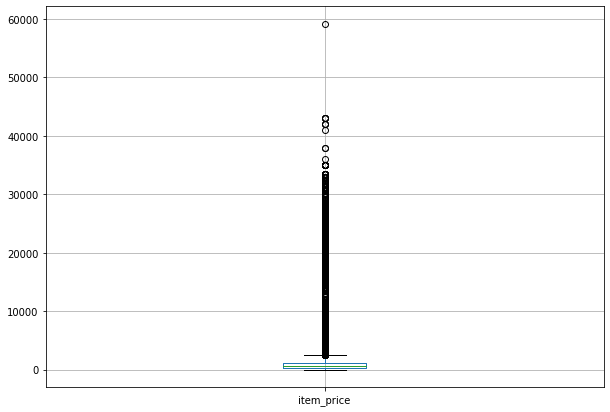

In [ ]:
# Visulizing outliers of item price
plt.figure(figsize=(10,7))
good_sales[["item_price"]].boxplot()

In [ ]:
# remove posible outliers in item_price
good_sales=good_sales[good_sales["item_price"]< 50000]

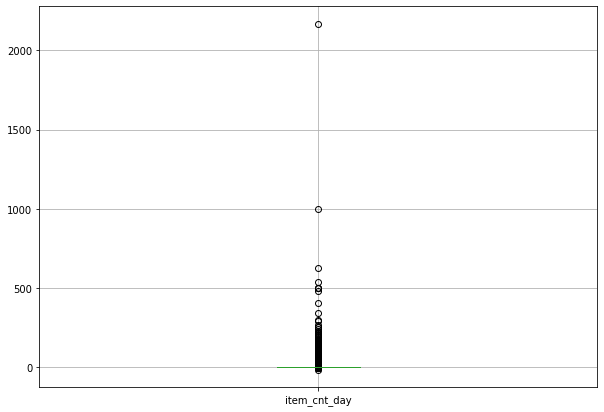

In [ ]:
# Visualizing outliers of item_cnt_day
plt.figure(figsize=(10,7))
good_sales[["item_cnt_day"]].boxplot()

In [ ]:
# Removing outliers in item_cnt_day
good_sales=good_sales[(good_sales["item_cnt_day"]<400) & (good_sales["item_cnt_day"]>0)]

In [ ]:
# Group data by SHOP and ITEM and get the amount of sales for each month in them

pivot_train=good_sales.pivot_table(index=["shop_id", "item_id"],
                                   columns= "date_block_num",
                                   values="item_cnt_day",
                                   aggfunc="sum").fillna(0.0)

pivot_train.head()                                   

date_block_num    0    1    2    3    4    5    6    7    8    9   ...   24  \
shop_id item_id                                                    ...        
2       30       0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  4.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        53       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
2       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
        32       0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
        33       1.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  
        53       1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [ ]:
# Cleaning the data
df_train_cleaned = pivot_train.reset_index()
df_train_cleaned["shop_id"]=df_train_cleaned.shop_id.astype("str")
df_train_cleaned["item_id"]=df_train_cleaned.item_id.astype("str")

#merge the items with categories
item_to_cat_df=items.merge(categories[["item_category_id", "item_category_name"]],
                           how="inner", on="item_category_id")[["item_id", "item_category_name"]]

item_to_cat_df["item_id"]= item_to_cat_df.item_id.astype('str')

#merge the train dataframe with item+categories dataframe

df_train_cleaned=df_train_cleaned.merge(item_to_cat_df, how="inner", on="item_id")

#Create label encoder
from sklearn import preprocessing
number = preprocessing.LabelEncoder()

# Encode the category column
df_train_cleaned["item_category_name"]= number.fit_transform(df_train_cleaned.item_category_name)

# Rearrange the columns
df_train_cleaned = df_train_cleaned[["shop_id", "item_id", "item_category_name"] +list(range(34))]

df_train_cleaned.head()

,shop_id,item_id,item_category_name,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,2,30,28,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,30,28,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4,30,28,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,30,28,0.0,5.0,7.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,6,30,28,0.0,28.0,10.0,4.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
item_to_cat_df.head()

,item_id,item_category_name
0,0,Кино - DVD
1,2,Кино - DVD
2,3,Кино - DVD
3,4,Кино - DVD
4,5,Кино - DVD


In [ ]:
df_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111403 entries, 0 to 111402
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   shop_id             111403 non-null  object 
 1   item_id             111403 non-null  object 
 2   item_category_name  111403 non-null  int64  
 3   0                   111403 non-null  float64
 4   1                   111403 non-null  float64
 5   2                   111403 non-null  float64
 6   3                   111403 non-null  float64
 7   4                   111403 non-null  float64
 8   5                   111403 non-null  float64
 9   6                   111403 non-null  float64
 10  7                   111403 non-null  float64
 11  8                   111403 non-null  float64
 12  9                   111403 non-null  float64
 13  10                  111403 non-null  float64
 14  11                  111403 non-null  float64
 15  12                  111403 non-nul

# Construct model to predict


In [ ]:
print(df_train_cleaned.keys())

Index([           'shop_id',            'item_id', 'item_category_name',
                          0,                    1,                    2,
                          3,                    4,                    5,
                          6,                    7,                    8,
                          9,                   10,                   11,
                         12,                   13,                   14,
                         15,                   16,                   17,
                         18,                   19,                   20,
                         21,                   22,                   23,
                         24,                   25,                   26,
                         27,                   28,                   29,
                         30,                   31,                   32,
                         33],
      dtype='object')


In [ ]:
print(df_train_cleaned.shape)

(111403, 37)


In [ ]:
import xgboost as xgb 
from sklearn.metrics import mean_squared_error

In [ ]:
df_train_cleaned.head()

,shop_id,item_id,item_category_name,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,2,30,28,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,30,28,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4,30,28,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,30,28,0.0,5.0,7.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,6,30,28,0.0,28.0,10.0,4.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
xgbtrain = xgb.DMatrix(df_train_cleaned.iloc[:, (df_train_cleaned.columns !=33)].values,
                       
                       df_train_cleaned.iloc[:, df_train_cleaned.columns==33].values)

watchlist = [(xgbtrain, "train-rmse")]

#Train model
bst = xgb.train(params= {"max_depth":15,
                "subsample": 0.999,
                "min_child_weight":1,
                "eta": 0.34,
                "seed":1,
                "verbosity":1,
                "eval_metric":"rmse"}, dtrain=xgbtrain)
preds = bst.predict(xgb.DMatrix(df_train_cleaned.iloc[:, (df_train_cleaned.columns !=33)].values)) 
rmse = np.sqrt(mean_squared_error(preds, df_train_cleaned.iloc[:, df_train_cleaned.columns ==33].values))

In [ ]:
print(rmse)

0.8758617950258897


In [ ]:
df_train_cleaned.iloc[:, (df_train_cleaned.columns !=33)].values

array([['2', '30', 28, ..., 0.0, 0.0, 0.0],
       ['3', '30', 28, ..., 1.0, 0.0, 0.0],
       ['4', '30', 28, ..., 0.0, 0.0, 0.0],
       ...,
       ['55', '22166', 36, ..., 8.0, 11.0, 5.0],
       ['57', '15925', 51, ..., 0.0, 0.0, 0.0],
       ['57', '18916', 28, ..., 0.0, 0.0, 0.0]], dtype=object)

In [ ]:
df_train_cleaned.iloc[:, df_train_cleaned.columns==33].values

array([[ 0.],
       [ 0.],
       [ 0.],
       ...,
       [11.],
       [ 1.],
       [ 0.]])

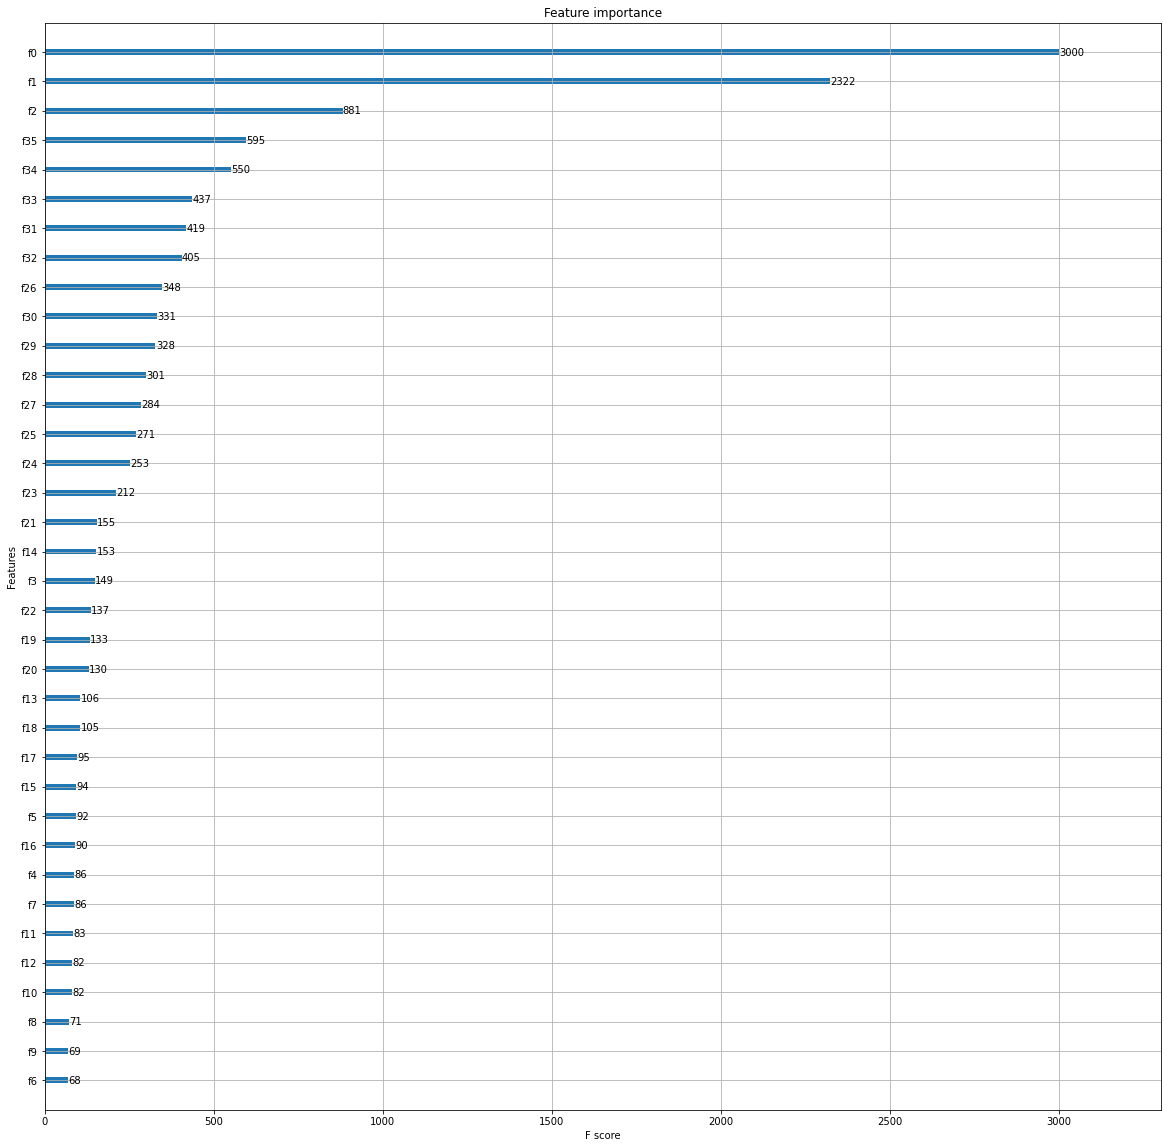

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
xgb.plot_importance(bst, ax = ax)

## Predictions on the test set

In [ ]:
df_test = df_sales_test
df_test["shop_id"]= df_test.shop_id.astype("str")
df_test["item_id"]=df_test.item_id.astype("str")

df_test= df_sales_test.merge(df_train_cleaned, how="left", on=["shop_id", "item_id"]).fillna(0.0)

df_test.head()

,ID,shop_id,item_id,item_category_name,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from datetime import datetime

In [ ]:
# Get the preds
preds = bst.predict(xgb.DMatrix(df_test.iloc[:, (df_test.columns !="ID") &(df_test.columns !=33)].values))

preds= list(map(lambda x: min(20, max(x,0)), list(preds)))
sub_df = pd.DataFrame({"ID": df_test.ID, "item_cnt_mont":preds})

now = datetime.now()
dt_string= now.strftime("%d_%m_%Y_%H_%M_%S")

sub_df.to_csv(f"out_using_matrix_xgb_{dt_string}.csv", index=False)


In [ ]:
#Get csv generated of predictions 
df_preds = pd.read_csv(f"out_using_matrix_xgb_{dt_string}.csv")
df_preds.tail()

,ID,item_cnt_mont
214195,214195,0.143587
214196,214196,0.095596
214197,214197,0.173447
214198,214198,0.043556
214199,214199,0.150090


In [ ]:
df_test.tail()

,ID,shop_id,item_id,item_category_name,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
214195,214195,45,18454,37.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,214196,45,16188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,214197,45,15757,37.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,214198,45,19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214199,214199,45,969,26.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
